---
### Import required libraries


In [1]:
import pandas as pd
from src.data.preprocess_data import *
from src.uniprot_client import UniprotClient
from src.data.dea import differential_expression_analysis
from src.stringdb_client import StringDBClient

# Import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

from igraph import Graph, plot
from Bio import SeqIO
import os

from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import linkage, dendrogram

import networkx as nx


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Setup logs**

---
### Set parameters / constants


In [2]:
# Path to the data
PATH_PROCESSED_DATA = './data/processed/2021_Leduc/'
NAME_EXPERIMENT = '2021_Leduc'


---
### Prepare data according the input format

In [3]:
# Load the data from the CSV file
prot_intensity = pd.read_csv(PATH_PROCESSED_DATA + 'prot_proc.csv')
# Rename the first column to 'protein'
prot_intensity = prot_intensity.rename(columns={'Unnamed: 0': 'protein'})
# First column as the index
prot_intensity = prot_intensity.set_index('protein')
# Convert values to float
prot_intensity.apply(pd.to_numeric, errors='coerce')

# Load the data from the CSV file
metadata = pd.read_csv(PATH_PROCESSED_DATA + 'anno.csv')
# Convert the first column to the index
metadata = metadata.set_index('Unnamed: 0')
# Replace the column names with the values of the first row
metadata.columns = metadata.iloc[0]
# Drop the first row from the metadata DataFrame
metadata = metadata.drop(metadata.index[0])


# Concatenate the metadata to the protein intensity data frame
# TODO: We assume that both data frames have the same order for the columns
prot_intensity = pd.concat([metadata, prot_intensity], axis=0, ignore_index=False)
print(prot_intensity.head())

                 i10      i102      i103      i104      i105      i106  \
celltype           H         U         U         U         H         H   
A0A024RBG1 -0.208326  0.317744   0.29467  0.381682 -0.187703 -0.267211   
A0A1B0GX78  0.195591 -0.122598 -0.627951  0.132455  0.153521  0.244738   
A0AVF1     -0.795366  0.114473  0.185542  0.258208 -0.260679  0.148852   
A1A4S6     -0.152512  0.060963  0.885153  0.314711 -0.345838 -0.549751   

                i107      i108      i109       i11  ...       i87       i88  \
celltype           H         H         H         H  ...         U         H   
A0A024RBG1 -0.103692 -0.264988  -0.35848 -0.366581  ...  0.542687 -0.493343   
A0A1B0GX78 -0.364624 -0.074277  0.251052  0.049257  ...  0.045749  0.271147   
A0AVF1      0.402998 -0.305016  0.323643 -0.425968  ... -0.032475  0.106257   
A1A4S6     -0.202808  0.021079 -0.307785  0.359791  ...  0.143857 -0.691573   

                 i89        i9       i90       i91       i92       i93  \
cellty

---

In [4]:
unipcl = UniprotClient()
gene_names = unipcl.batch_translate_protein_ids(prot_intensity.index[1:])
prot_intensity.index = [gene_names.get(i, i) for i in prot_intensity.index]


In [5]:
print(prot_intensity.head())

               i10      i102      i103      i104      i105      i106  \
celltype         H         U         U         U         H         H   
NUDT4B   -0.208326  0.317744   0.29467  0.381682 -0.187703 -0.267211   
TRBV12-5  0.195591 -0.122598 -0.627951  0.132455  0.153521  0.244738   
IFT56    -0.795366  0.114473  0.185542  0.258208 -0.260679  0.148852   
ARHGAP10 -0.152512  0.060963  0.885153  0.314711 -0.345838 -0.549751   

              i107      i108      i109       i11  ...       i87       i88  \
celltype         H         H         H         H  ...         U         H   
NUDT4B   -0.103692 -0.264988  -0.35848 -0.366581  ...  0.542687 -0.493343   
TRBV12-5 -0.364624 -0.074277  0.251052  0.049257  ...  0.045749  0.271147   
IFT56     0.402998 -0.305016  0.323643 -0.425968  ... -0.032475  0.106257   
ARHGAP10 -0.202808  0.021079 -0.307785  0.359791  ...  0.143857 -0.691573   

               i89        i9       i90       i91       i92       i93  \
celltype         H         U    



---
### Statistic analysis

**Number of single-cells samples and Number of proteins found**

In [6]:
print("Number of Single-cell samples:", prot_intensity.shape[1])
print("Number of Proteins:", prot_intensity.shape[0]-1)

Number of Single-cell samples: 163
Number of Proteins: 1647


**Plot protein intensities**

In [7]:
# Create another dataframe without the first row
prot_intensity_no_metadata = prot_intensity.iloc[1:, :]

# Finding the min value and its position
min_value = prot_intensity_no_metadata.min().min()
min_position = prot_intensity_no_metadata.stack().idxmin()

# Finding the max value and its position
max_value = prot_intensity_no_metadata.max().max()
max_position = prot_intensity_no_metadata.stack().idxmax()

print(f"Minimum value: {min_value} at position (row, column): {min_position}")
print(f"Maximum value: {max_value} at position (row, column): {max_position}")


Minimum value: -3.37626703921849 at position (row, column): ('ATP1A4', 'i231')
Maximum value: 3.63979305113291 at position (row, column): ('PNOC', 'i120')


In [8]:
prot_intensity_T = prot_intensity.T
prot_intensity_T = prot_intensity_T.drop(columns=['celltype'])
print(prot_intensity_T.head())


        NUDT4B  TRBV12-5     IFT56  ARHGAP10     LAMB4    EFCAB5      BDP1  \
i10  -0.208326  0.195591 -0.795366 -0.152512 -0.083936  0.262566 -0.330972   
i102  0.317744 -0.122598  0.114473  0.060963  0.287396  0.097426  0.579381   
i103   0.29467 -0.627951  0.185542  0.885153  0.297342  0.107372  0.727271   
i104  0.381682  0.132455  0.258208  0.314711  0.283589  0.093619  0.713518   
i105 -0.187703  0.153521 -0.260679 -0.345838 -0.184337 -0.025293 -0.327262   

        GRXCR2    ANKUB1     MROH6  ...    GTF3C5     RBM8A     SNX11  \
i10   0.684506  0.970011 -0.880989  ...  1.362794 -0.090204 -0.131163   
i102  1.443848  -0.99663  1.202588  ... -1.386451 -0.651874  0.216465   
i103  1.453794 -0.943628   -0.0521  ... -1.544113 -0.149517  0.226411   
i104  1.440041 -1.500282  0.624641  ... -1.390258 -0.456611  0.105575   
i105 -1.190058  0.060566  0.064436  ...  0.997089  0.340324 -0.119809   

         FHOD1     PSAT1    ADGRG1   EMILIN1   ARFGEF1     DDX49    DUSP10  
i10  -0.119977 

In [9]:
# Split the dataframe by "celltype"
prot_intensity_U = prot_intensity.loc[:, prot_intensity.loc['celltype'] == 'U']
prot_intensity_H = prot_intensity.loc[:, prot_intensity.loc['celltype'] == 'H']

# Remove the row "celltype"
prot_intensity_U = prot_intensity_U.drop('celltype')
prot_intensity_H = prot_intensity_H.drop('celltype')

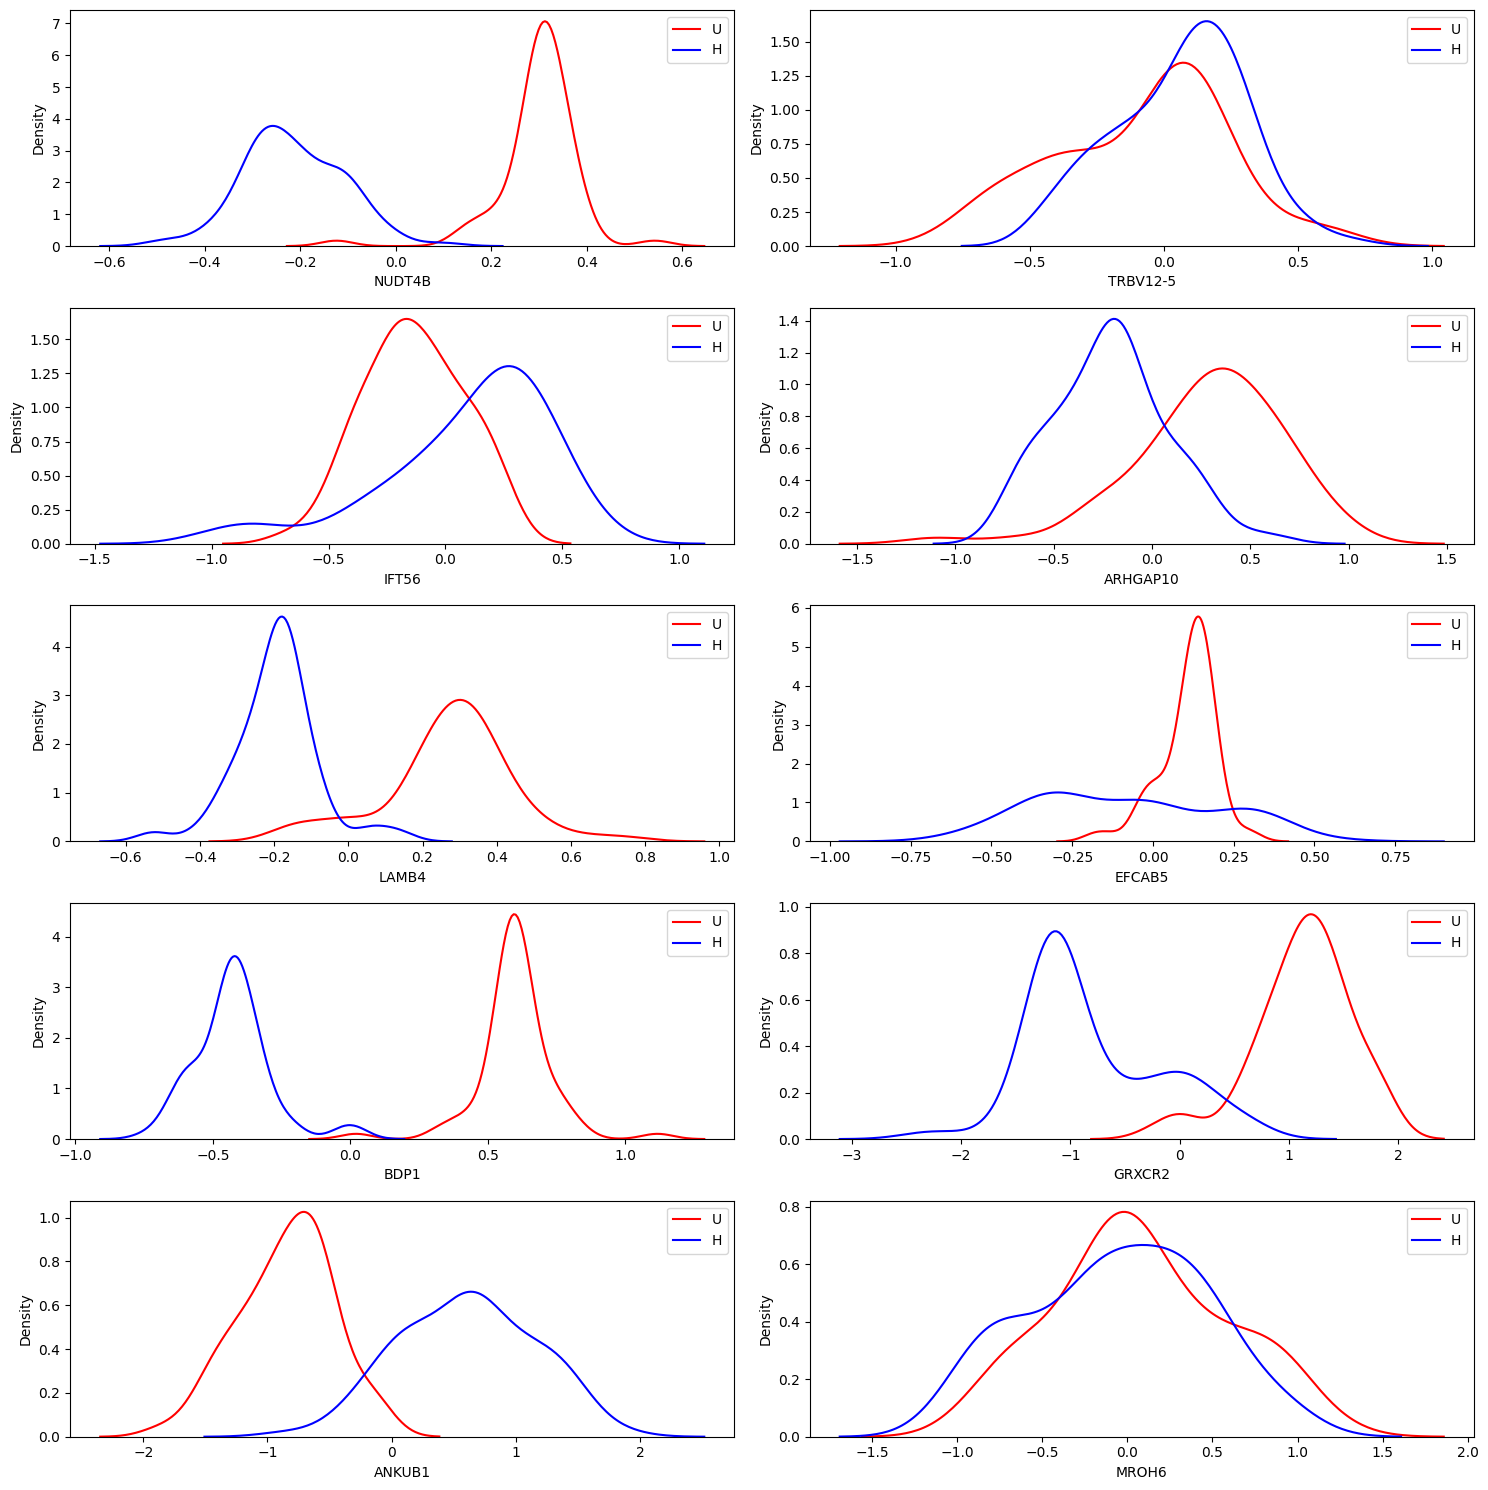

In [10]:
# Density plots of the first 10 proteins 
index = prot_intensity_U.index

fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i in range(0, 10, 2):
    sns.kdeplot(prot_intensity_U.loc[index[i], :], color='red', ax=axs[int(i/2), 0])
    sns.kdeplot(prot_intensity_H.loc[index[i], :], color='blue', ax=axs[int(i/2), 0])
    
    sns.kdeplot(prot_intensity_U.loc[index[i+1], :], color='red', ax=axs[int(i/2), 1])
    sns.kdeplot(prot_intensity_H.loc[index[i+1], :], color='blue', ax=axs[int(i/2), 1])

    axs[int(i/2), 0].legend(['U', 'H'])
    axs[int(i/2), 1].legend(['U', 'H'])

plt.tight_layout()
plt.show()

**Perform a PCA**

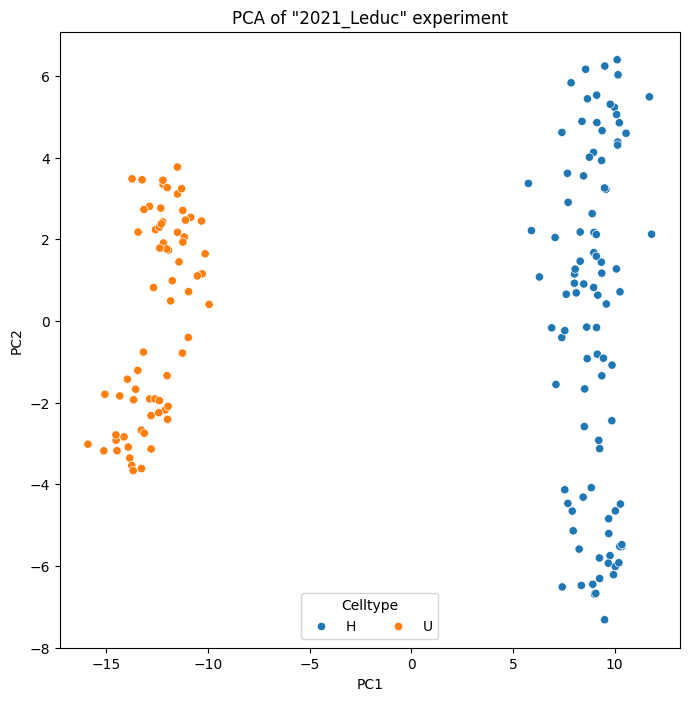

In [11]:
# Perform a PCA 
pca = PCA(n_components=2)

# Transpose the data
pca_data = prot_intensity.T

X = pca_data.iloc[:, 1:]
Y = pca_data.iloc[:, 0]

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the principalDf
pca_df = pd.concat([principalDf , Y], axis=1)

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='celltype')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()



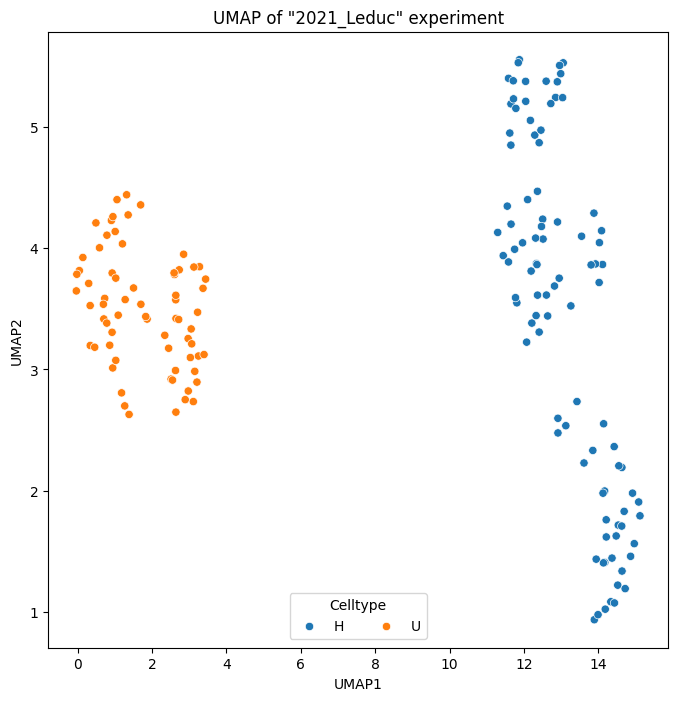

In [12]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X)

umap_df = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2'])
umap_df.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the umap_df
umap_df = pd.concat([umap_df , Y], axis=1)

# Plot the UMAP and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('UMAP of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='celltype')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()


**Differential Expression Analysis**

**Check also https://biocorecrg.github.io/CRG_Bioinformatics_for_Biologists/differential_gene_expression.html**

**Independent (Two-sample) t-test**
Independent t-test to compare protein intensities between two different conditions (celltypes).

**Hypotheses**
* **Null hypothesis (𝐻0):** The means of the two groups are equal (no difference).
* **Alternative hypothesis (𝐻𝑎)**: The means of the two groups are not equal (there is a difference).

**Assumptions**

* The data is approximately normally distributed.
* The variances of the two groups are equal (homogeneity of variance).
* The samples are independent.


**Parameters for the t-test function**

* **Data_U**: Protein intensities from celltype U.
* **Data_H**: Protein intensities from celltype H.
* **Equal variance assumption**: Whether to assume equal variance between groups (equal_var parameter).

In [13]:
data_H = prot_intensity_H
data_U = prot_intensity_U

data_H = data_H.apply(pd.to_numeric, errors='coerce')
data_U = data_U.apply(pd.to_numeric, errors='coerce')

# Initialize lists to store results
proteins = index
t_stats = []
p_values = []

# Loop through each protein and perform a t-test
for protein in proteins:
    group1 = data_H.loc[protein].values
    group2 = data_U.loc[protein].values
    t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
    t_stats.append(t_stat)
    p_values.append(p_val)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Gene': proteins,
    'T-statistic': t_stats,
    'P-value': p_values
})

print(results_df)


          Gene  T-statistic       P-value
0       NUDT4B   -34.047661  1.830475e-75
1     TRBV12-5     3.309310  1.154076e-03
2        IFT56     4.681878  6.001528e-06
3     ARHGAP10    -9.588347  1.660108e-17
4        LAMB4   -21.242468  1.463226e-48
...        ...          ...           ...
1642    ADGRG1    -5.679437  6.165551e-08
1643   EMILIN1   -31.552515  7.841184e-71
1644   ARFGEF1    11.769895  1.812358e-23
1645     DDX49     9.744773  6.314033e-18
1646    DUSP10    -6.301361  2.708100e-09

[1647 rows x 3 columns]


In [14]:
# Count number of results with p-value < 0.05
significant_results = results_df[results_df['P-value'] < 0.05]
print(f"Number of significant results: {len(significant_results)}")

# Sort the results by p-value
sorted_results = results_df.sort_values(by='P-value')
print(sorted_results.head())


Number of significant results: 1314
         Gene  T-statistic        P-value
151    ERLIN1  -121.704020  2.175712e-160
183     ABCA8   101.149498  1.275441e-147
1398  C2orf49    91.593196  8.450031e-141
1336   MEGF10   -79.661969  2.988108e-131
1351    FMNL2    75.234965  2.340141e-127


In [15]:
# Create a new data frame with the 100 more significant proteins
significant_100_proteins = sorted_results.head(100)

# Create a data frame with the intensities of the 100 more significant proteins
significant_100_proteins_intensity = prot_intensity.loc[significant_100_proteins['Gene']]

# Transform values to numeric
significant_100_proteins_intensity = significant_100_proteins_intensity.apply(pd.to_numeric, errors='coerce')

# Concatenate the metadata value to the current columnname
significant_100_proteins_intensity.columns = prot_intensity.columns + '_' + prot_intensity.loc['celltype']

significant_100_proteins_intensity

,i10_H,i102_U,i103_U,i104_U,i105_H,i106_H,i107_H,i108_H,i109_H,i11_H,...,i87_U,i88_H,i89_H,i9_U,i90_H,i91_H,i92_H,i93_H,i95_U,i96_U
ERLIN1,-0.446342,0.826869,0.500618,0.552025,-0.443200,-0.460604,-0.245817,-0.431748,-0.457063,-0.471707,...,0.631430,-0.447201,-0.441250,0.579009,-0.390646,-0.374534,-0.462299,-0.457679,0.613485,0.622734
ABCA8,0.902138,-1.210187,-1.200241,-1.213994,0.854164,0.799540,0.859304,0.790637,0.784203,0.878905,...,-1.216208,0.600830,0.827716,-1.115157,0.644152,1.039377,1.016917,0.754559,-1.234153,-1.224905
C2orf49,0.628458,-0.851945,-0.841999,-0.855752,0.710235,0.557894,0.715375,0.548991,0.542558,0.527952,...,-0.853634,0.572344,0.762895,-0.774000,0.619703,0.491820,0.469360,0.586130,-0.871579,-0.862330
MEGF10,-0.583745,0.953337,0.963283,0.949531,-0.623172,-0.508387,-0.728807,-0.628499,-0.722321,-0.765664,...,0.957083,-0.685475,-0.680230,0.879218,-0.642146,-0.626034,-0.724384,-0.499733,0.939137,0.948386
FMNL2,0.183288,-0.341761,-0.383163,-0.396916,0.201236,0.256160,0.325598,0.315132,0.276805,0.324552,...,-0.388031,0.268108,0.187558,-0.346973,0.258652,0.274765,0.319512,0.211998,-0.405976,-0.351095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAPH1,0.219563,-0.363951,-0.354006,-0.367758,0.196484,0.311643,0.201624,0.302740,0.296307,0.296943,...,-0.354072,0.474512,0.192246,-0.293924,0.375820,0.131035,0.108575,0.283496,-0.372017,-0.362768
KANSL1,0.264312,-0.403327,-0.393382,-0.407134,0.344089,0.173364,0.349229,0.164460,0.158027,0.257784,...,-0.475845,0.132891,0.329720,-0.399374,0.203457,0.260065,0.237604,0.125962,-0.276321,-0.267072
NUBP1,0.456874,-0.619497,-0.565332,-0.734057,0.411625,0.634557,0.381409,0.406298,0.447124,0.206825,...,-0.695899,0.646916,0.637466,-0.345542,0.191360,0.355324,0.221656,0.621744,-0.601082,-0.704596
BRCA2,-0.060245,0.107316,0.117262,0.103510,-0.051401,-0.047825,-0.046261,-0.056728,-0.063161,-0.085610,...,0.115077,-0.049399,-0.044154,0.110638,-0.058855,-0.042742,-0.065203,-0.059876,0.097131,-0.016156


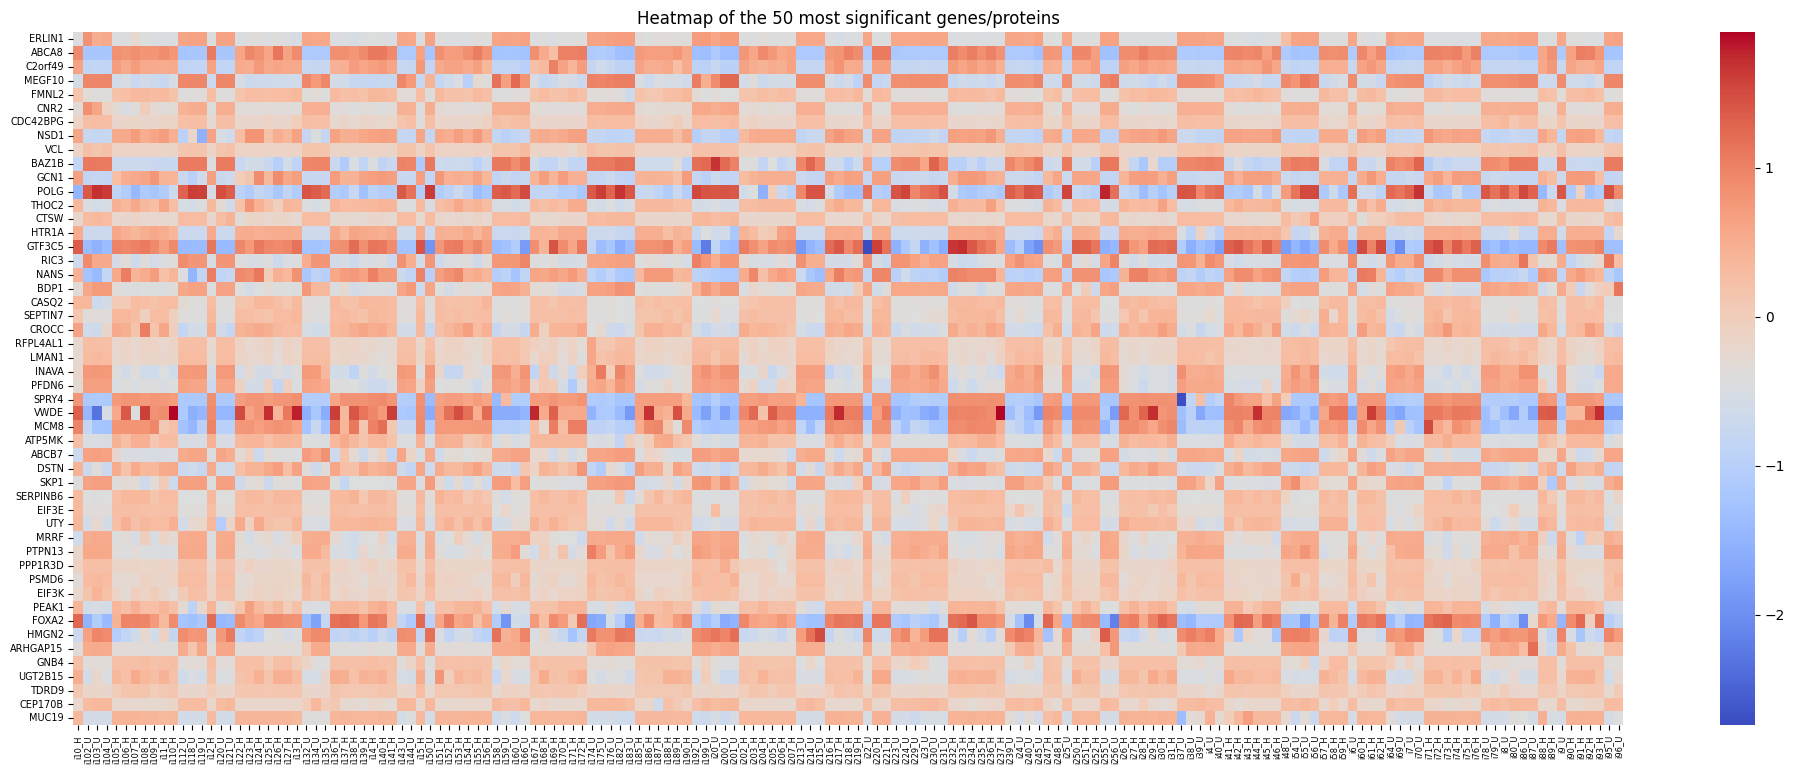

In [16]:
# Create a new data frame with the 50 more significant proteins
significant_50_proteins = sorted_results.head(50)

# Create a data frame with the intensities of the 50 more significant proteins
significant_50_proteins_intensity = prot_intensity.loc[significant_50_proteins['Gene']]

# Transform values to numeric
significant_50_proteins_intensity = significant_50_proteins_intensity.apply(pd.to_numeric, errors='coerce')

# Concatenate the metadata value to the current columnname
significant_50_proteins_intensity.columns = prot_intensity.columns + '_' + prot_intensity.loc['celltype']

# Plot the heatmap with the names of the proteins and samples with small font type
plt.figure(figsize=(25, 9))
sns.heatmap(significant_50_proteins_intensity, cmap='coolwarm', xticklabels=1, yticklabels=1,  annot=False) # Coolwarm
plt.title('Heatmap of the 50 most significant genes/proteins')
plt.xticks(fontsize=6)
plt.yticks(fontsize=7)
plt.show()



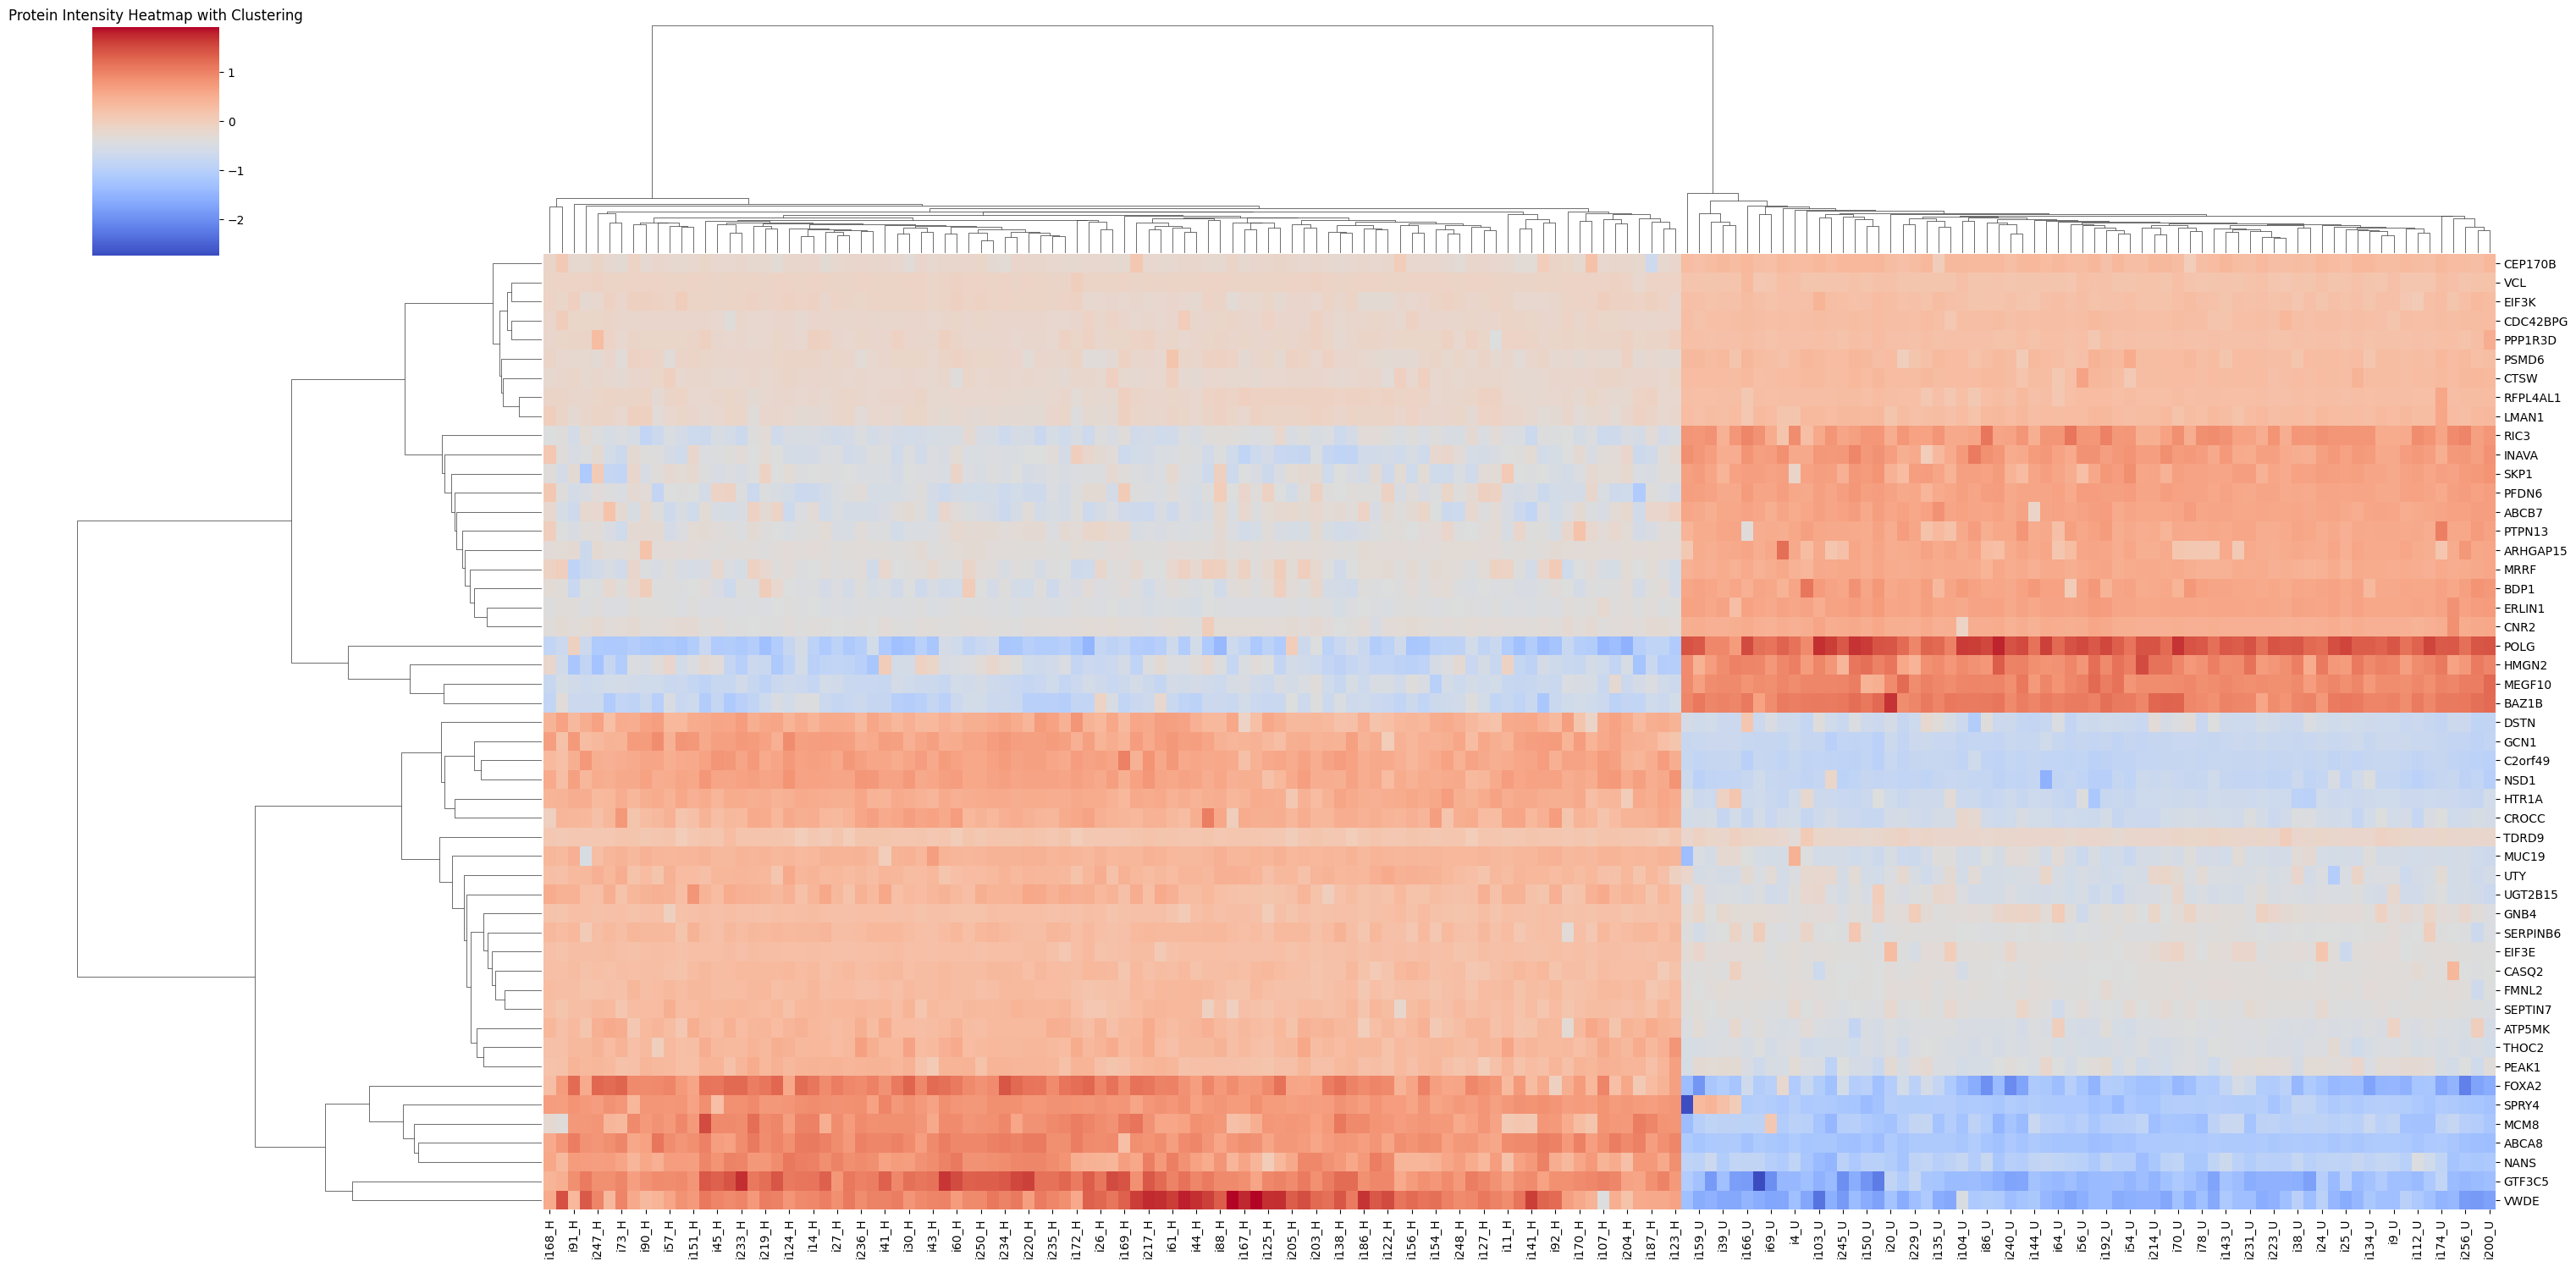

In [17]:
# Ensure that the data is numeric
significant_50_proteins_intensity = significant_50_proteins_intensity.apply(pd.to_numeric, errors='coerce')

# Clustering the data for better visualization
# Perform hierarchical clustering on rows and columns
row_linkage = linkage(significant_50_proteins_intensity, method='average')
col_linkage = linkage(significant_50_proteins_intensity.T, method='average')

# Create the heatmap with clustering with warm colors using the correct row and column names
sns.clustermap(significant_50_proteins_intensity, row_linkage=row_linkage, col_linkage=col_linkage, cmap='coolwarm', figsize=(30, 15))
plt.title('Protein Intensity Heatmap with Clustering')


plt.show()



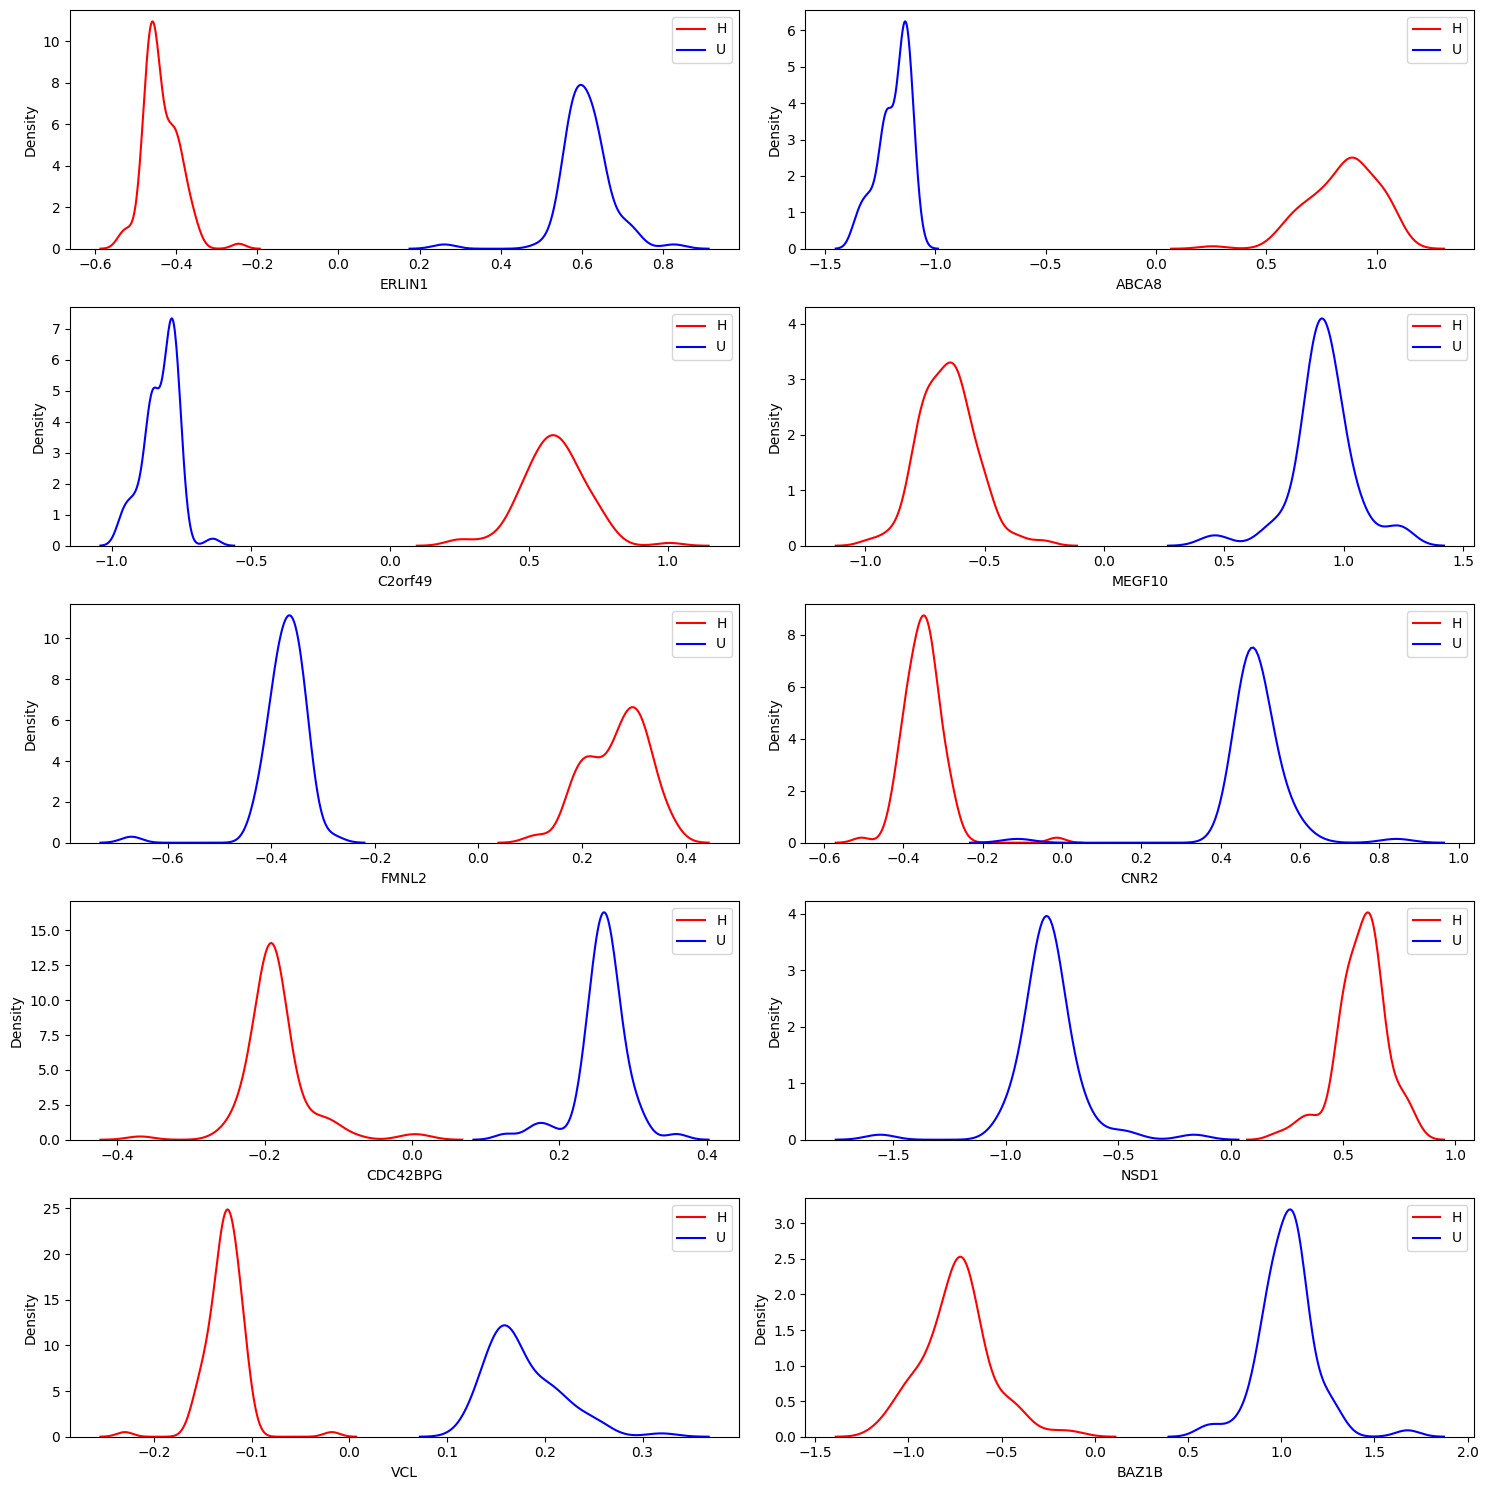

In [18]:
# Density plot of the top 10 proteins with the lowest p-values
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i in range(0, 10, 2):
    sns.kdeplot(data_H.loc[sorted_results.iloc[i, 0], :], color='red', ax=axs[int(i/2), 0])
    sns.kdeplot(data_U.loc[sorted_results.iloc[i, 0], :], color='blue', ax=axs[int(i/2), 0])
    
    sns.kdeplot(data_H.loc[sorted_results.iloc[i+1, 0], :], color='red', ax=axs[int(i/2), 1])
    sns.kdeplot(data_U.loc[sorted_results.iloc[i+1, 0], :], color='blue', ax=axs[int(i/2), 1])

    axs[int(i/2), 0].legend(['H', 'U'])
    axs[int(i/2), 1].legend(['H', 'U'])

plt.tight_layout()
plt.show()



---
#### Functional Enrichment Analysis

**StringDB Client**

In [19]:
sdb = StringDBClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

In [20]:
# Functional Enrichment Analysis for the 10 most significant proteins
top10_proteins = sorted_results.iloc[:10, 0].values

# For each protein, get enriched terms
for protein in top10_proteins:
    #functional = sdb.get_annotations(protein, "tsv")
    enrich = sdb.get_enrichment(protein, "json")
    #print("Protein: " + protein + "= " + functional)
    print("Protein: " + protein + "= " + enrich)
    print("\n")


Protein: ERLIN1= [{"category": "COMPARTMENTS", "term": "GOCC:0005789", "number_of_genes": 7, "number_of_genes_in_background": 538, "ncbiTaxonId": 9606, "inputGenes": ["FAF2", "AMFR", "RNF185", "VCP", "SYVN1", "ERLIN1", "ERLIN2"], "preferredNames": ["FAF2", "AMFR", "RNF185", "VCP", "SYVN1", "ERLIN1", "ERLIN2"], "p_value": 3.57e-09, "fdr": 5.1e-06, "description": "Endoplasmic reticulum membrane"}, {"category": "COMPARTMENTS", "term": "GOCC:0098827", "number_of_genes": 7, "number_of_genes_in_background": 502, "ncbiTaxonId": 9606, "inputGenes": ["FAF2", "AMFR", "RNF185", "VCP", "SYVN1", "ERLIN1", "ERLIN2"], "preferredNames": ["FAF2", "AMFR", "RNF185", "VCP", "SYVN1", "ERLIN1", "ERLIN2"], "p_value": 2.22e-09, "fdr": 5.1e-06, "description": "Endoplasmic reticulum subcompartment"}, {"category": "COMPARTMENTS", "term": "GOCC:0005783", "number_of_genes": 8, "number_of_genes_in_background": 1095, "ncbiTaxonId": 9606, "inputGenes": ["FAF2", "AMFR", "RNF185", "VCP", "SYVN1", "UBAC2", "ERLIN1", "ER

**TODO:** https://version-12-0.string-db.org/cgi/input?sessionId=bcWKH0EpYxT2&input_page_active_form=proteins_with_values

In [21]:
prot_intensity_enr = prot_intensity.copy()
prot_intensity_enr['U_mean'] = prot_intensity_U.mean(axis=1)
prot_intensity_enr['H_mean'] = prot_intensity_H.mean(axis=1)

prot_intensity_enr = prot_intensity_enr[['U_mean', 'H_mean']]
prot_intensity_enr = prot_intensity_enr.drop('celltype')

print(prot_intensity_enr.head())

# add the fold change as a new colmun for each of the proteins as the difference between the mean of the two cell types
epsilon = 1e-6
for protein in prot_intensity_enr.index:
    prot_intensity_enr.loc[protein, 'fold_change'] = prot_intensity_enr.loc[protein, 'H_mean'] - (prot_intensity_enr.loc[protein, 'U_mean'] - epsilon)



# drop the mean columns
#prot_intensity_enr = prot_intensity_enr.drop(columns=['U_mean', 'H_mean'])

print(prot_intensity_enr)
# Save the data to a CSV file
prot_intensity_enr.to_csv(PATH_PROCESSED_DATA + 'prot_intensity_enr.csv')



            U_mean    H_mean
NUDT4B    0.299365 -0.214282
TRBV12-5 -0.085563  0.061245
IFT56    -0.134295  0.096127
ARHGAP10  0.291155 -0.208406
LAMB4     0.270131 -0.193357
            U_mean    H_mean  fold_change
NUDT4B    0.299365 -0.214282    -0.513646
TRBV12-5 -0.085563  0.061245     0.146809
IFT56    -0.134295  0.096127     0.230422
ARHGAP10  0.291155 -0.208406    -0.499560
LAMB4     0.270131 -0.193357    -0.463487
...            ...       ...          ...
ADGRG1    0.206575 -0.147864    -0.354438
EMILIN1   0.646085 -0.462461    -1.108544
ARFGEF1   -0.28999  0.207571     0.497562
DDX49    -0.381585  0.273134     0.654720
DUSP10    0.152566 -0.109205    -0.261770

[1647 rows x 3 columns]


**Once saved the file 'prot_intensity_enr.csv' with the fold change value, we use it to do the "Proteins with Values/Ranks - Functional Enrichment Analysis" in StringDB website:**

https://version-12-0.string-db.org/cgi/input?sessionId=bcWKH0EpYxT2&input_page_active_form=proteins_with_values



In [22]:
# Get the top 50 proteins with the lowest p-values
top_proteins = sorted_results.iloc[:50, 0].values

# Get the STRING IDs for the top proteins
mapped_proteins = sdb.map_proteins(top_proteins, output_format="tsv-no-header")

# Parse the STRING interactions
interactions = []
for line in mapped_proteins.strip().split("\n"):
    parts = line.split("\t")
    if len(parts) >= 5:
        interactions.append((parts[0], parts[1], float(parts[5])))

mapped_proteins

'9606.ENSP00000211998\t9606.ENSP00000246069\tVCL\tDSTN\t9606\t0.437\t0\t0\t0\t0.141\t0\t0\t0.371\n9606.ENSP00000220849\t9606.ENSP00000418695\tEIF3E\tPSMD6\t9606\t0.55\t0\t0\t0\t0.262\t0\t0\t0.414\n9606.ENSP00000220849\t9606.ENSP00000248342\tEIF3E\tEIF3K\t9606\t0.999\t0\t0\t0\t0.638\t0.997\t0.9\t0.912\n9606.ENSP00000231487\t9606.ENSP00000418695\tSKP1\tPSMD6\t9606\t0.538\t0\t0\t0\t0.166\t0\t0.4\t0.15\n9606.ENSP00000232564\t9606.ENSP00000316244\tGNB4\tHTR1A\t9606\t0.744\t0\t0\t0\t0\t0.292\t0.65\t0.05\n9606.ENSP00000248342\t9606.ENSP00000418695\tEIF3K\tPSMD6\t9606\t0.593\t0\t0\t0\t0.216\t0\t0\t0.501\n9606.ENSP00000343867\t9606.ENSP00000442047\tMRRF\tUTY\t9606\t0.441\t0.12\t0\t0\t0.3\t0\t0\t0.166\n9606.ENSP00000343867\t9606.ENSP00000355228\tMRRF\tHMGN2\t9606\t0.824\t0.106\t0\t0\t0.386\t0.624\t0\t0.251\n9606.ENSP00000351575\t9606.ENSP00000361180\tBDP1\tGTF3C5\t9606\t0.871\t0\t0\t0\t0\t0.114\t0.54\t0.709\n9606.ENSP00000355228\t9606.ENSP00000442047\tHMGN2\tUTY\t9606\t0.418\t0\t0\t0\t0.347\t0.0

In [23]:
interactions

[('9606.ENSP00000211998', '9606.ENSP00000246069', 0.437),
 ('9606.ENSP00000220849', '9606.ENSP00000418695', 0.55),
 ('9606.ENSP00000220849', '9606.ENSP00000248342', 0.999),
 ('9606.ENSP00000231487', '9606.ENSP00000418695', 0.538),
 ('9606.ENSP00000232564', '9606.ENSP00000316244', 0.744),
 ('9606.ENSP00000248342', '9606.ENSP00000418695', 0.593),
 ('9606.ENSP00000343867', '9606.ENSP00000442047', 0.441),
 ('9606.ENSP00000343867', '9606.ENSP00000355228', 0.824),
 ('9606.ENSP00000351575', '9606.ENSP00000361180', 0.871),
 ('9606.ENSP00000355228', '9606.ENSP00000442047', 0.418),
 ('9606.ENSP00000368164', '9606.ENSP00000399851', 0.445),
 ('9606.ENSP00000395929', '9606.ENSP00000442047', 0.429)]

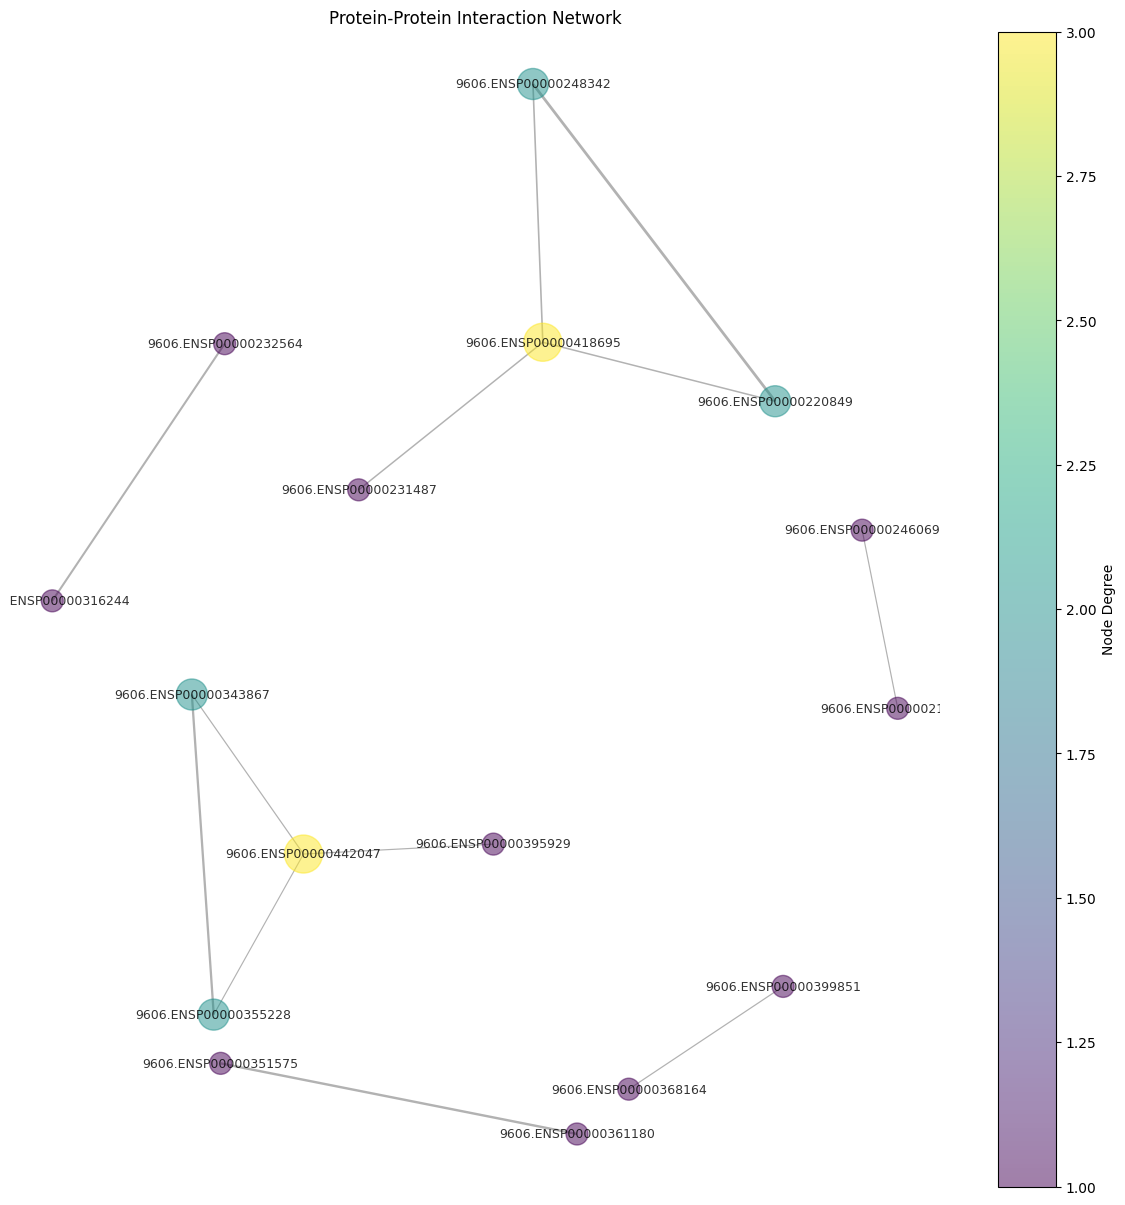

In [24]:
# Create a networkx graph from the interactions between top 50 proteins

G = nx.Graph()
G.add_weighted_edges_from(interactions)

# Calculate degrees (number of connections) for node sizing and coloring
degree_dict = dict(G.degree(G.nodes()))
node_size = [v * 250 for v in degree_dict.values()]
node_color = [degree_dict[node] for node in G.nodes()]


# Get edge weights for line thickness
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]

# Plot the network
plt.figure(figsize=(15, 15))
#pos = nx.planar_layout(G, scale=1)  # k controls the distance between nodes
#pos = nx.spring_layout(G, k=0.4)  # k controls the distance between nodes
pos = nx.kamada_kawai_layout(G)  # k controls the distance between nodes

# Draw nodes with customized size and color
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.5, margins=0.00000001)
#nodes.set_edgecolor('black')  # Outline nodes in black

# Draw edges with customized width
edges = nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='grey')

# Draw labels
labels = nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif', alpha=0.8, font_color='black')

# Add color bar for node degree
plt.colorbar(nodes, label='Node Degree')

# Remove axes for better aesthetics
plt.axis('off')
plt.title('Protein-Protein Interaction Network')
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  ERLIN1
https://string-db.org/cgi/link?to=041A6948FAB8988D



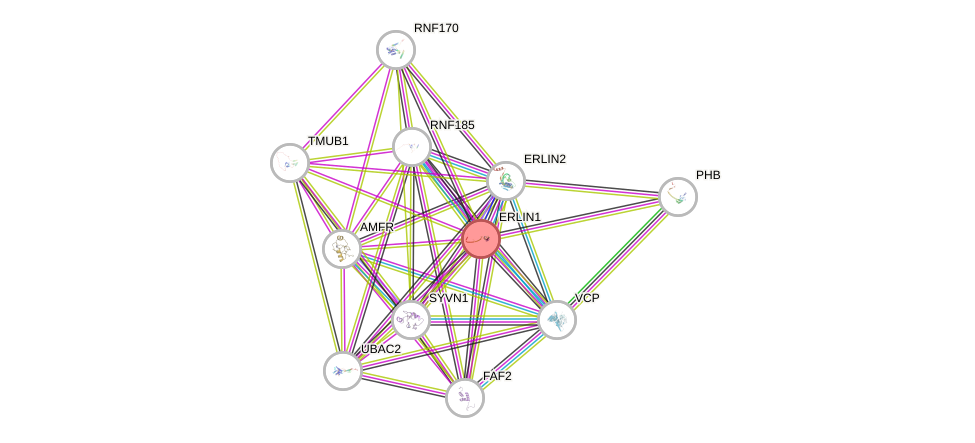

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  ABCA8
https://string-db.org/cgi/link?to=E5417A03B9F6E2B4



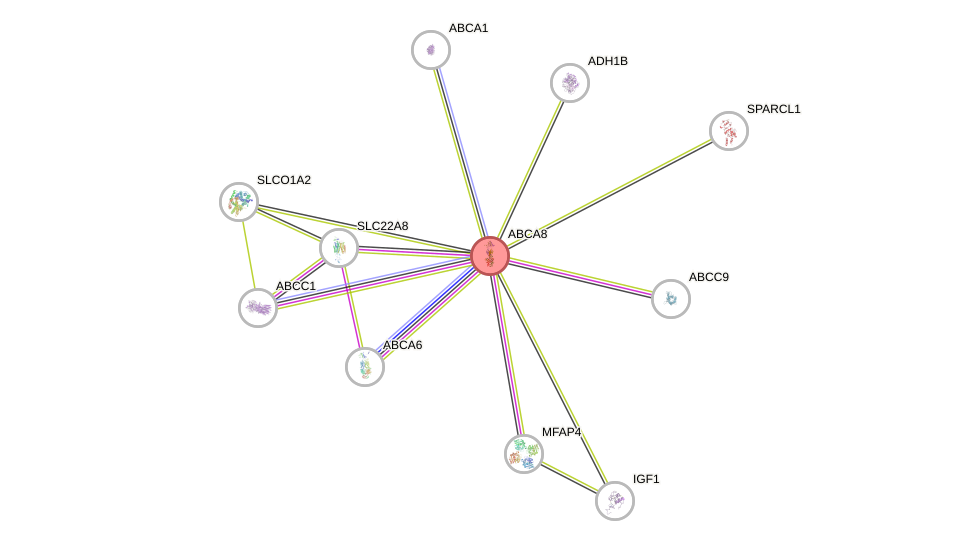

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  C2orf49
https://string-db.org/cgi/link?to=27D011BC75BDB1E8



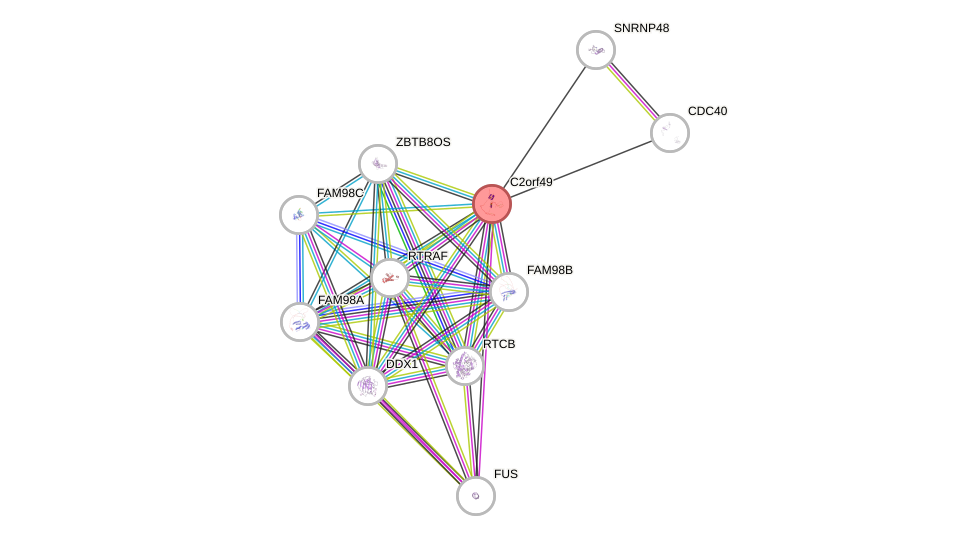

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  MEGF10
https://string-db.org/cgi/link?to=1FD439F9BA177A18



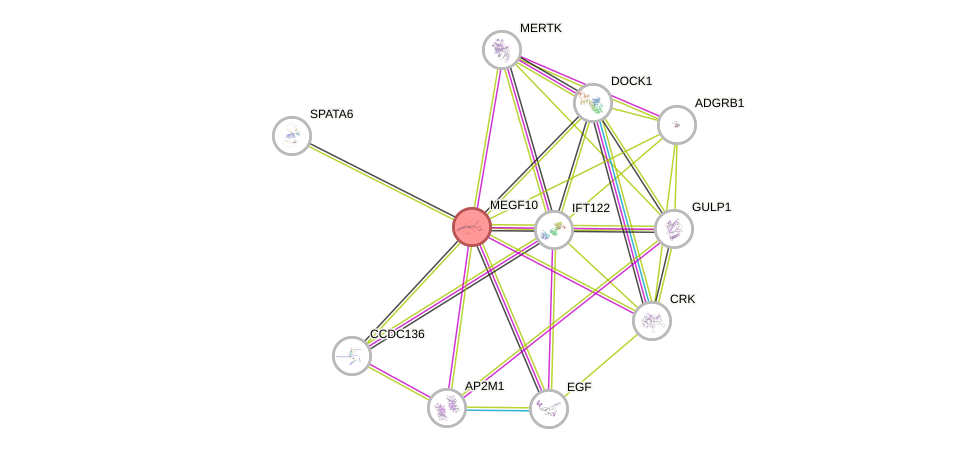

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  FMNL2
https://string-db.org/cgi/link?to=F2E02A8A2C39BCAC



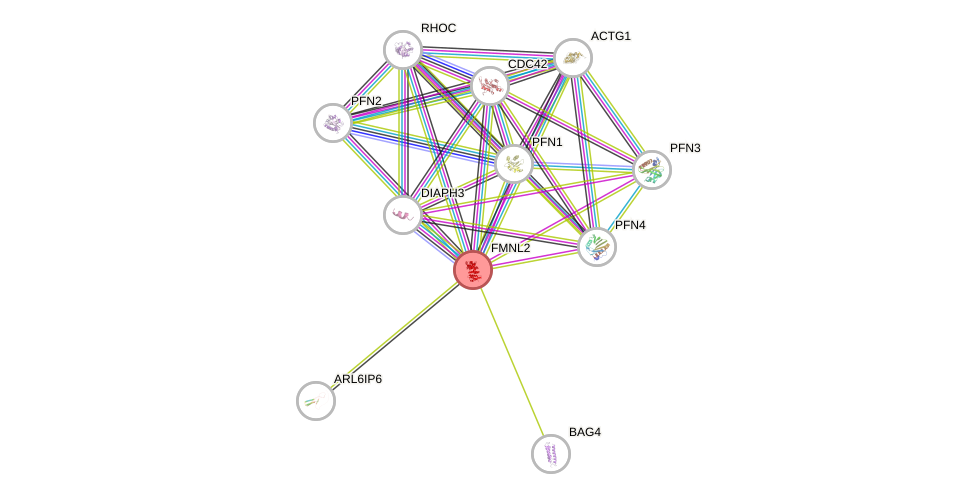

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  CNR2
https://string-db.org/cgi/link?to=B120BD5283C93334



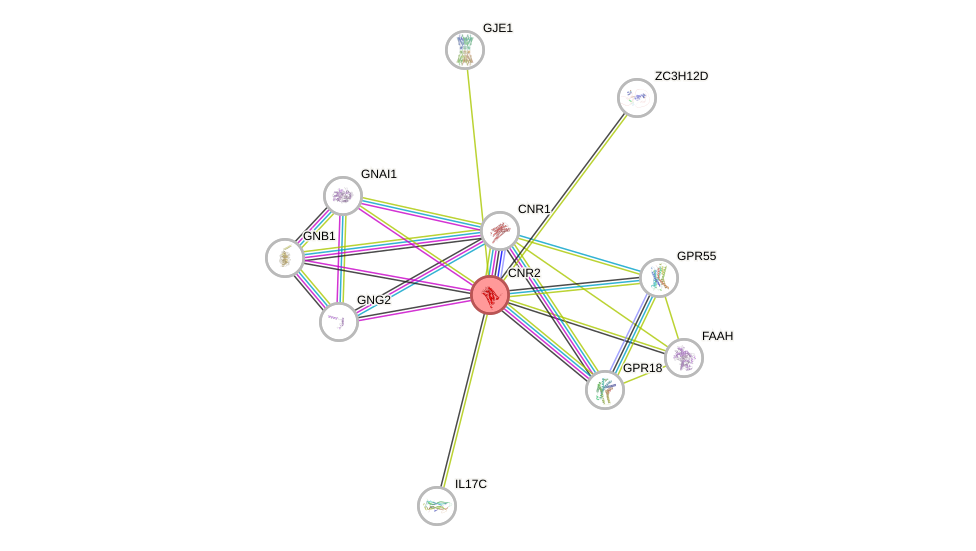

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  CDC42BPG
https://string-db.org/cgi/link?to=F9AEEA2168AD364D



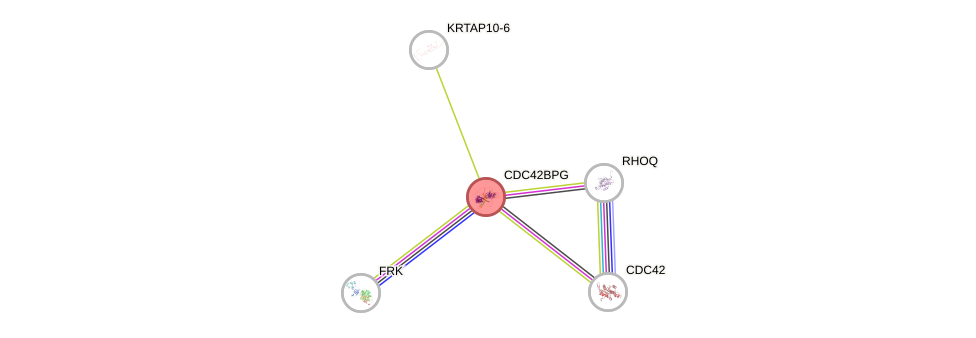

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  NSD1
https://string-db.org/cgi/link?to=A53F8CF3AB342E66



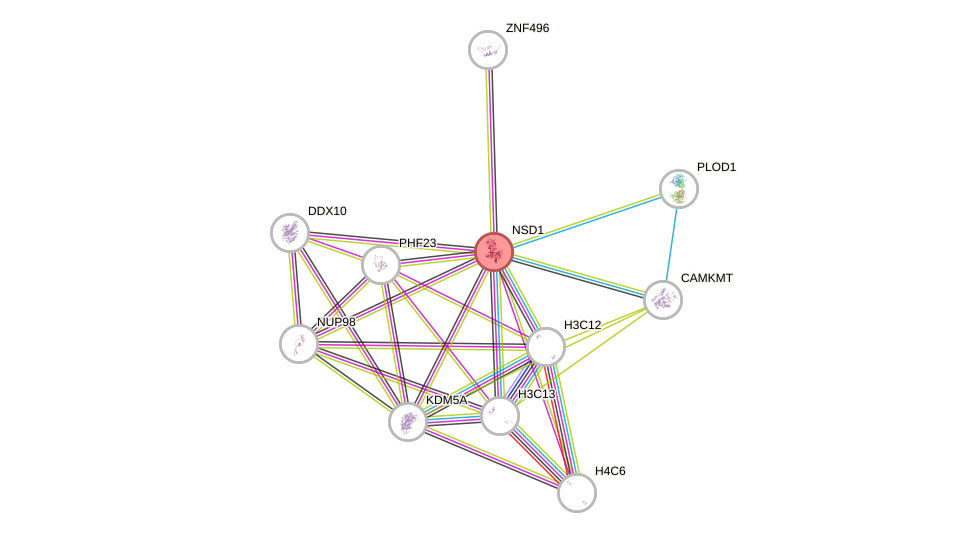

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  VCL
https://string-db.org/cgi/link?to=72EA2C4BA1B2A1CF



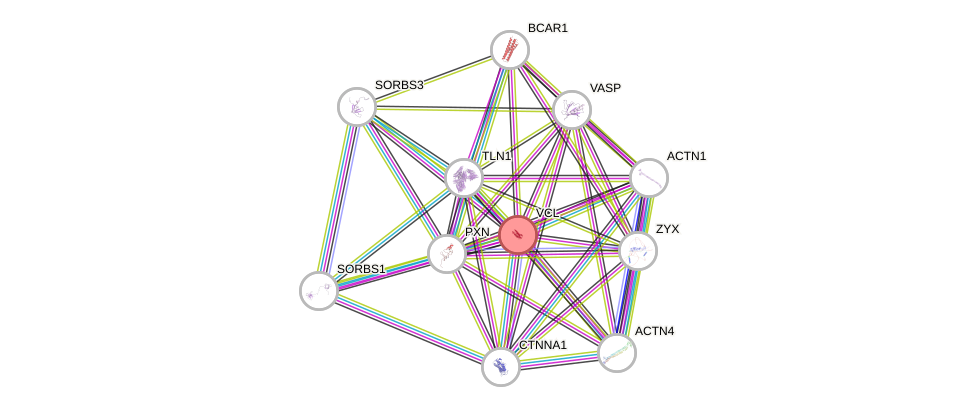

------------------------------------------------------------------------------------------------------------------------------------------------------
Protein:  BAZ1B
https://string-db.org/cgi/link?to=8CB96895C1C4B6BC



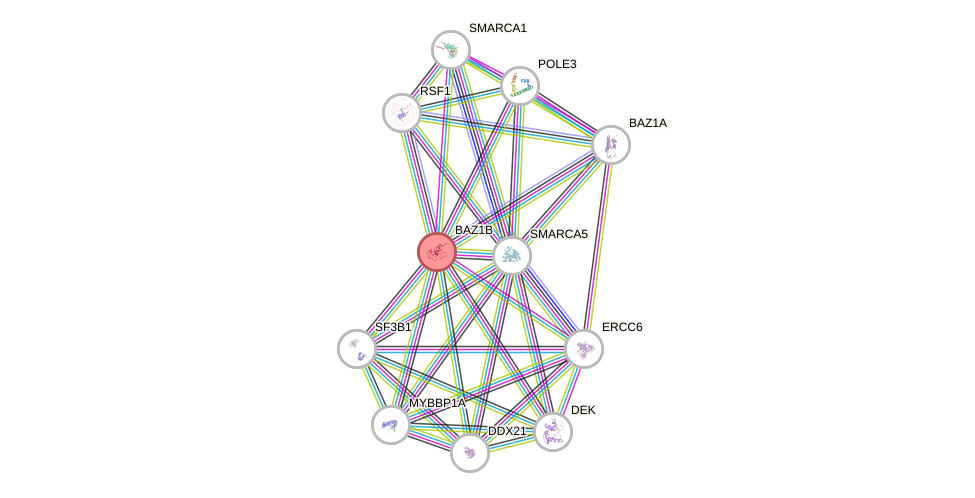

In [25]:
from IPython.display import Image, display


# Get the network of the top 10 proteins
for protein in top10_proteins:
    print("-" * 150)
    print("Protein: ", protein)
    image_data = sdb.get_network_image(protein, "image")
    page = sdb.get_protein_page(protein, "tsv-no-header")

    print(page)
    display(Image(image_data))


___
# Adding Cell Cycle proteins


In [26]:
# Load Cell Cycle Proteins Metadata
cell_cycle_proteins = pd.read_csv(PATH_PROCESSED_DATA + 'CellCycle_ProteinAnnotations.csv')

# Rename the second column to "phase"
cell_cycle_proteins = cell_cycle_proteins.rename(columns={'PHASE': 'phase'})

# Remove the first column
cell_cycle_proteins = cell_cycle_proteins.drop(columns=['Unnamed: 0'])

# Convert the first column to the index
cell_cycle_proteins = cell_cycle_proteins.set_index('prot')

# Drop the first row
cell_cycle_proteins = cell_cycle_proteins.drop(cell_cycle_proteins.index[0])

#cell_cycle_proteins.columns = cell_cycle_proteins.columns.droplevel('protein')
cell_cycle_proteins

,phase
prot,
P39748,S phase
O15440,S phase
P11142,M/G1
P40429,M/G1
Q16881,G2/M
P23246,G2/M
O15392,G2/M
Q02224,G2/M
P02545,G2/M


In [27]:

# Perform PCA but this time only with the intensities of the proteins idetified as part of the cell cycle.
# Add the celltype row to the pca_data_filtered
pca_data_filtered = pd.concat([prot_intensity.iloc[0:1], prot_intensity.loc[cell_cycle_proteins.index]], axis=0)

# Add a row with the name "phase" with empty values
pca_data_filtered.loc['phase'] = ''

# Iterate over all columns, find the highest value and set as a phase the corresponding value in cell_cycle_proteins for that protein
for column in pca_data_filtered.columns:
    # set protein as the value of the index
    protein = pca_data_filtered.loc[cell_cycle_proteins.index, column]
    max_value = protein.max()
    max_index = protein.idxmax()
    phase = cell_cycle_proteins.loc[max_index, 'phase']
    pca_data_filtered.loc['phase', column] = phase


# One hot encoding for the row "phase" (categorical data)
#pca_data_filtered = pd.get_dummies(pca_data_filtered, columns=pca_data_filtered.loc['phase'])


# One hot encoding for the column "phase" (categorical data)
pca_data_filtered = pd.get_dummies(pca_data_filtered.T, columns=['phase'])

# Convert boolean values to numeric
yy = pca_data_filtered.T[0:1]
pca_data_filtered = pca_data_filtered.T[1:].apply(pd.to_numeric, errors='coerce')

pca_data_filtered = pd.concat([yy, pca_data_filtered], axis=0)

print(pca_data_filtered)

# Convert all values to numeric
#pca_data_filtered = pca_data_filtered.apply(pd.to_numeric, errors='coerce')

# Slit in two dataframes based on the celltype
pca_data_filtered_U = pca_data_filtered.loc[:, pca_data_filtered.loc['celltype'] == 'U']
pca_data_filtered_H = pca_data_filtered.loc[:, pca_data_filtered.loc['celltype'] == 'H']

#print(pca_data_filtered_U.head())
#print(pca_data_filtered_H.head())

# Create a new column with the average of the values for each row except those of the 5th last columns
#pca_data_filtered_U['average'] = pca_data_filtered_U.iloc[:-5, :].mean(axis=1)
#pca_data_filtered_H['average'] = pca_data_filtered_H.iloc[:-5, :].mean(axis=1)



#print(pca_data_filtered_U)

KeyError: "None of [Index(['P39748', 'O15440', 'P11142', 'P40429', 'Q16881', 'P23246', 'O15392',\n       'Q02224', 'P02545', 'P08670', 'O43670', 'P62942', 'P11388', 'Q9UKL3',\n       'P12004', 'P49321', 'P49736', 'P07339', 'Q14566'],\n      dtype='object', name='prot')] are in the [index]"

In [ ]:

# Perform PCA but this time only with the intensities of the proteins idetified as part of the cell cycle.
# Add the celltype row to the pca_data_filtered
pca_data_filtered = pd.concat([prot_intensity.iloc[0:1], prot_intensity.loc[cell_cycle_proteins.index]], axis=0)

# Add a row with the name "phase" with empty values
pca_data_filtered.loc['phase'] = ''

# Iterate over all columns, find the highest value and set as a phase the corresponding value in cell_cycle_proteins for that protein
for column in pca_data_filtered.columns:
    # set protein as the value of the index
    protein = pca_data_filtered.loc[cell_cycle_proteins.index, column]
    max_value = protein.max()
    max_index = protein.idxmax()
    phase = cell_cycle_proteins.loc[max_index, 'phase']
    pca_data_filtered.loc['phase', column] = phase


print(pca_data_filtered)

In [ ]:
# PCA per cycle cell phase
pca = PCA(n_components=2)

# Transpose the data
pca_data = pca_data_filtered.T

X = pca_data.iloc[:, 1:-1]
Y = pca_data.iloc[:, -1]

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_data.index

# Concatenate the 1st row with the cell cycle phase
pca_df = pd.concat([principalDf , Y], axis=1)

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of Cycle Cell Phase - "{0}"'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='phase')
plt.legend(title='Phase', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()


In [ ]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

umap_df = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2'])
umap_df.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the umap_df
umap_df = pd.concat([umap_df , Y], axis=1)

# Plot the UMAP and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('UMAP of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='phase')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

In [ ]:
# PCA per cycle cell phase (Only H cells)
pca = PCA(n_components=2)

# Use only the cell type = H
pca_data_filtered_H = pca_data_filtered.loc[:, pca_data_filtered.loc['celltype'] == 'H']

# Transpose the data
pca_data = pca_data_filtered_H.T

X = pca_data.iloc[:, 1:-1]
Y = pca_data.iloc[:, -1]


principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_data.index

# Concatenate the 1st row with the cell cycle phase
pca_df = pd.concat([principalDf , Y], axis=1)

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of Cycle Cell Phase (Only H cells) - "{0}"'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='phase')
plt.legend(title='Phase', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()


In [ ]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

umap_df = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2'])
umap_df.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the umap_df
umap_df = pd.concat([umap_df , Y], axis=1)

# Plot the UMAP and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('UMAP of Cycle Cell Phase (Only H cells) - "{0}"'.format(NAME_EXPERIMENT))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='phase')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

In [ ]:
# PCA per cycle cell phase (Only U cells)
pca = PCA(n_components=2)

# Use only the cell type = U
pca_data_filtered_U = pca_data_filtered.loc[:, pca_data_filtered.loc['celltype'] == 'U']

# Transpose the data
pca_data = pca_data_filtered_U.T

X = pca_data.iloc[:, 1:-1]
Y = pca_data.iloc[:, -1]


principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_data.index

# Concatenate the 1st row with the cell cycle phase
pca_df = pd.concat([principalDf , Y], axis=1)

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of Cycle Cell Phase (Only U cells) - "{0}"'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='phase')
plt.legend(title='Phase', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()


In [ ]:
# UMAP
reducer = umap.UMAP()

embedding = reducer.fit_transform(X)

umap_df = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2'])
umap_df.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the umap_df
umap_df = pd.concat([umap_df , Y], axis=1)

# Plot the UMAP and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('UMAP of Cycle Cell Phase (Only U cells) - "{0}"'.format(NAME_EXPERIMENT))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='phase')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

---

# Tests

In [ ]:
# Perform a differential expression analysis with a volcano plot. Take all the proteins and compare the intensities of the U and H cells.

import numpy as np
import matplotlib.pyplot as plt

# Perform a differential expression analysis
dea_results = differential_expression_analysis(prot_intensity, 'U', 'H')

# Create a volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(dea_results['log2(fold_change)'], -np.log10(dea_results['p_value']), color='blue', alpha=0.5)
plt.xlabel('Log2(Fold Change)')
plt.ylabel('-Log10(p-value)')
plt.title('Volcano Plot of Differential Expression Analysis')
plt.show()




### Anova

In [ ]:
# Anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=['Protein', 'p-value', 'logFC'])

# Loop through each protein to perform differential expression analysis
for protein in log_data.index:
    # Prepare the data for this protein
    df = pd.DataFrame({'intensity': log_data.loc[protein].values, 'group': group})
    
    # Fit the linear model
    model = ols('intensity ~ C(group)', data=df).fit()
    
    # Perform an ANOVA (Analysis of Variance) test
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract the p-value
    p_value = anova_table['PR(>F)']['C(group)']
    
    # Extract the log fold change (logFC)
    logFC = model.params['C(group)[T.treatment]']
    
    # Store the results
    results = results.append({'Protein': protein, 'p-value': p_value, 'logFC': logFC}, ignore_index=True)

# View the results
results.head()


In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply the Benjamini-Hochberg correction
results['adj_p-value'] = multipletests(results['p-value'], method='fdr_bh')[1]

# View the results with adjusted p-values
results.head()


In [ ]:
# Set a significance threshold
alpha = 0.05

# Filter for significantly differentially expressed proteins
significant_proteins = results[results['adj_p-value'] < alpha]

# View the significant proteins
significant_proteins.head()


---

In [ ]:
#X_U = pca_data_filtered_U.iloc[1:, :]
#X['average_u'] = X_U.mean(axis=0)
#print(X.head())


#X_H = pca_data_filtered_H.iloc[1:, :]
#X['average_h'] = X_H.mean(axis=0)
#print(X.head())

# Drop all columns but the average and celltype
#X = X[['average_u', 'average_h']]


print(X.T)
# For each of the proteins, calculate the average intensity for each cell type (H and U) and add it to the X dataframe
for protein in pca_data_filtered.T.index[1:]:
    X[protein + '_u'] = pca_data_filtered_U.loc[protein].mean()
    X[protein + '_h'] = pca_data_filtered_H.loc[protein].mean()

print(X.head())





In [ ]:
X_U = pca_data_filtered_U.iloc[:, 1:-1]
X_H = pca_data_filtered_H.iloc[:, 1:-1]

print("1111111")
print(X_U.head())
print("x1111111")

X_U1 = X_U.iloc[:, 1:-4]
X_U2 = X_U.iloc[:, -4:]

X_H1 = X_H.T.iloc[:, 1:-4]
X_H2 = X_H.T.iloc[:, -4:]

print("22222222")
print(X_U1.head())
print("x22222222")

# Create a column named "average" with the average of the values for each row
X_U1['average'] = X_U1.mean(axis=1)
X_H1['average'] = X_H1.mean(axis=1)

# Remove all columns except the "average" column
X_U1 = X_U1[['average']]
X_H1 = X_H1[['average']]

X_U = pd.concat([X_U1, X_U2], axis=1)
X_H = pd.concat([X_H1, X_H2], axis=1)


print("------")
print(X_U.head())
print("----")

# Y first column of filtered data
Y = pca_filtered_data.iloc[:, 0]
# Y2 = last column only


print("xxxxxxxx")
print(Y.head())

print("xxxxxxxx")

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_filtered_data.index

# Concatenate the 1st row of prot_intensity to the principalDf
pca_df = pd.concat([principalDf , Y], axis=1)

# Concatenate the cell cycle phase to the pca_df
#pca_df = pd.merge(pca_df, cell_cycle_proteins, how='outer', left_index=True, right_index=True)

print(pca_df.head())

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='celltype')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()

In [ ]:
X = pca_filtered_data_U.iloc[:, 1:-1]

X1 = X.iloc[:, :-4]
# Create a column named "average" with the average of the values for each row



X2 = X.iloc[:, -4:]

print(X1.head())
print(X2.head())
# Y first column of filtered data
Y = pca_filtered_data.iloc[:, 0]
# Y2 = last column only


print(Y.head())


principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_filtered_data.index

# Concatenate the 1st row of prot_intensity to the principalDf
pca_df = pd.concat([principalDf , Y], axis=1)

# Concatenate the cell cycle phase to the pca_df
#pca_df = pd.merge(pca_df, cell_cycle_proteins, how='outer', left_index=True, right_index=True)

print(pca_df.head())

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='celltype')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()

In [ ]:
# Transpose the data
pca_filtered_data = pca_data_filtered.T



#print(pca_filtered_data )

# Convert all the values to numeric except the last column
#pca_filtered_data.iloc[:, :-1] = pca_filtered_data.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')


# X = all columns except the first and the last

X = pca_filtered_data.iloc[:, 1:-1]
#print(X)
# Y first column of filtered data
Y = pca_filtered_data.iloc[:, 0]
# Y2 = last column only
Y2 = pca_filtered_data.iloc[:, -1]


print(Y.head())
print(Y2.head())


principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_filtered_data.index

# Concatenate the 1st row of prot_intensity to the principalDf
pca_df = pd.concat([principalDf , Y, Y2], axis=1)

# Concatenate the cell cycle phase to the pca_df
#pca_df = pd.merge(pca_df, cell_cycle_proteins, how='outer', left_index=True, right_index=True)

print(pca_df.head())

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='celltype', style='phase')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()



___

# Others (Deprecated)


In [ ]:
# Create a network with the interactions
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(interactions)

# Calculate degrees (number of connections) for node sizing and coloring
degree_dict = dict(G.degree(G.nodes()))
node_size = [v * 300 for v in degree_dict.values()]
node_color = [degree_dict[node] for node in G.nodes()]

# Plot the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, node_size=node_size, width=1, node_color=node_color, margins=0.00000001, alpha=0.5)
#nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Blues, margins=0.00000001)
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
plt.show()

In [ ]:
proteins = data.index.tolist()
proteins = proteins[:50]

In [ ]:
# Map proteins to STRING IDs
mapped_proteins = sdb.map_proteins(proteins, "tsv-no-header")
 
# Parse the STRING interactions
interactions = []
for line in mapped_proteins.strip().split("\n"):
    parts = line.split("\t")
    if len(parts) >= 5:
        interactions.append((parts[0], parts[1], float(parts[5])))

mapped_proteins

In [ ]:
interactions

In [ ]:
# Create an networkx object from the interactions
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(interactions)


# Plot the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=200, width=1)
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Generating random data for the example
import numpy as np
np.random.seed(0)

# Example dataframe
proteins = [f'Protein{i+1}' for i in range(1000)]
samples = [f'Sample{j+1}' for j in range(50)]
data = np.random.rand(1000, 50)
df = pd.DataFrame(data, index=proteins, columns=samples)

# Clustering the data for better visualization
# Perform hierarchical clustering on rows and columns
row_linkage = linkage(df, method='average')
col_linkage = linkage(df.T, method='average')

# Create the heatmap with clustering
sns.clustermap(df, row_linkage=row_linkage, col_linkage=col_linkage, cmap='viridis', figsize=(15, 10))
plt.title('Protein Intensity Heatmap with Clustering')
plt.show()